# Make a software package for generating train/test data

+ Utilities for combining models / directional forcing
+ 

In [1]:
import sys

import matplotlib.pyplot as plt

from thom import *
from thom.utils import *

%load_ext autoreload
%autoreload 2

## Improve stochastic integration

In [30]:
@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

coarse_timeline = np.linspace(0, 1, 100)
timeline = np.linspace(0., 1., 500)
x = my_process(x0=1, paths=10,
               steps=100)(coarse_timeline)
x.shape

(100, 10)

In [36]:
x = my_process(x0=1, paths=10,
               steps=100)(coarse_timeline)

In [70]:
# grn_process(x0=np.random.random((dim_eq, n_traj)) - 0.5, 
#                 paths=n_traj , 
#                 steps=1000, 
#                 vshape=dim_eq)

In [56]:
grn = BifurcatingGeneNetwork(4, 0.5)

@sdepy.integrate
def grn_process(t, x, sigma=0.1):
    return {'dt': grn(x, t)[None, :], 'dw': sigma}

# coarse_tvals = [0, 95, 100]
# fine_tvals = np.linspace(0, 100, 1000)
# sol = grn_process(x0=np.random.random((n_genes, n_cells)) - 0.5, 
#                 paths=n_cells, 
#                 steps=1000, 
#                 vshape=n_genes)(fine_tvals)

# plt.plot(sol[:, 0, :]);

In [58]:
grn(np.array([.4, .4, .4]), 0).shape

(4, 3)

In [50]:
grn(np.array([.4, .4, .4]), 0)

array([[ 0.136     ,  0.136     ,  0.136     ],
       [-0.29847625, -0.29847625, -0.29847625],
       [-0.00905596, -0.00905596, -0.00905596]])

In [67]:
eqf(np.array([.4, .4, .4]), 0)

array([[ 0.    , 10.64  , -0.9068],
       [ 0.    , 10.64  , -0.9068],
       [ 0.    , 10.64  , -0.9068],
       [ 0.    , 10.64  , -0.9068]])

In [69]:
import sdepy

eq = Lorenz()
# eqf = lambda x, t : np.vstack([eq(item, t) for item in x]).T
def eqf(x, t):
    rhs = [np.array(eq(x, t))]
    return np.vstack(3*rhs)

@sdepy.integrate
def grn_process(t, x, sigma=0.1):
    return {'dt': eqf(x, t)[None, :], 'dw': sigma}

# sol = grn_process(x0=np.array(ic)[:, None], 
#                 paths=1, 
#                 steps=1000, 
#                 vshape=3)(tpts)

# sol = grn_process(x0=np.array(ic)[:, None], 
#                 paths=1, 
#                 steps=1000, 
#                 vshape=3)(tpts)

# dim_eq = 3
# n_traj = 10
# sol = grn_process(x0=np.random.random((dim_eq, n_traj)) - 0.5, 
#                 paths=n_traj , 
#                 steps=1000, 
#                 vshape=dim_eq)(np.linspace(0,10,100))

TypeError: test evaluation of <function grn_process at 0x7fc58037a1f0> failed

## Make Lorenz Ensemble for classification

In [ ]:
def make_ensemble(model, n_samples, frac_perturb_param=.1, 
                  n_classes=2, frac_transient=0.1, ic_range=None,
                  random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.
    
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    num_per_class = int(n_samples/n_classes)

    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params
    
num_samples = 120

data, labels = generate_lorenz_ensemble(np.linspace(0, 500, 125000), 2*num_samples, (10, 28, 2.5), 
                                    n_classes=8, frac_perturb_param=.2, frac_transient=.2)


In [9]:
# def generate_lorenz_ensemble(tpts0, n_samples, params, frac_perturb_param=.1, 
#                              n_classes=2, frac_transient=0.1, 
#                              ic_range=None,
#                             random_state=0):
#     """
#     Generate an ensemble of trajectories with random initial conditions, labelled by different
#     sets of parameters.
    
#     tpts : the timesteps over which to run the simulation
#     params : iterable, the starting values for the parameters
#     n_samples : int, the number of different initial conditons
#     n_classes : int , the number of different parameters
#     frac_perturb_param : float, the amount to perturb the parameters by
#     frac_transient : float, the fraction of time for the time series to settle onto the attractor
#     ic_range : a starting value for the initial conditions
#     random_state : int, the seed for the random number generator
#     """
#     np.random.seed(random_state)
    
#     ntpts = len(tpts0)
#     dt = tpts0[1] - tpts0[0]
#     t_range = tpts0[-1] - tpts0[0]
#     tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
#     num_per_class = int(n_samples/n_classes)

#     all_params = list()
#     all_samples = list()
#     for i in range(n_classes):
    
#         params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
#         params_prime = params*params_perturb
#         all_params.append(params_prime)
    
#         eq = Lorenz(*params_prime)
        
#         all_samples_per_class = list()
#         for j in range(num_per_class):
#             ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
#             sol = integrate_dyn(eq, ic_prime, tpts)
            
#             all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
#         all_samples.append(all_samples_per_class)
    
#     all_samples, all_params = np.array(all_samples), np.array(all_params)
#     return all_samples, all_params
    
# num_samples = 120

# data, labels = generate_lorenz_ensemble(np.linspace(0, 500, 125000), 2*num_samples, (10, 28, 2.5), 
#                                     n_classes=8, frac_perturb_param=.2, frac_transient=.2)


# Sprott family

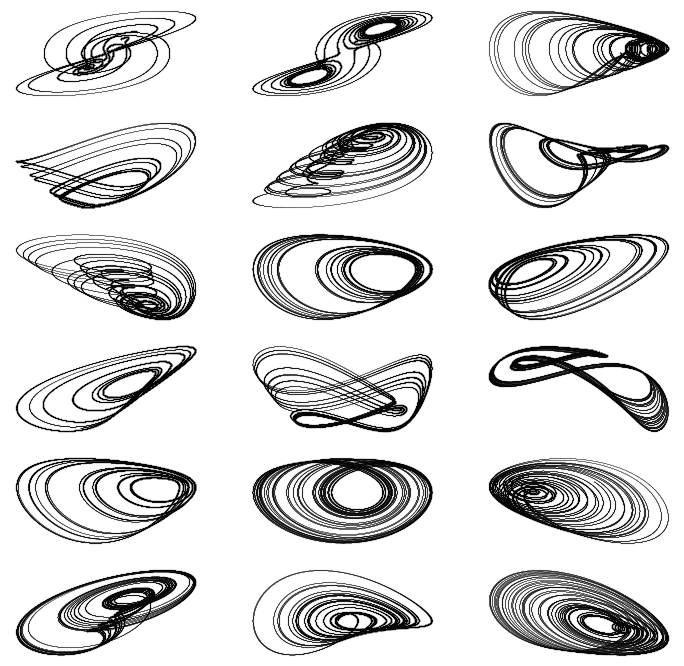

In [2]:
np.random.seed(0)
all_ensembles = list()
plt.figure(figsize=(12, 12))
for i, model in enumerate([SprottB(), SprottC(), SprottD(), SprottE(), SprottF(), SprottG(), 
              SprottH(), SprottI(), SprottJ(), SprottK(), SprottL(), SprottM(),
              SprottN(), SprottO(),SprottP(), SprottQ(), SprottR(), SprottS()]):
    
    
#     tpts = resample_timepoints(model, ic, tpts, pts_per_period=800)
    sol = model.make_trajectory(100000)
    
    plt.subplot(6, 3, i+1)
    plt.plot(sol[0], sol[1], '.k', markersize=.1)

#     ensemble = generate_ic_ensemble(model, tpts, 5, frac_perturb_param=.2)
#     all_ensembles.append(ensemble)
    
    plt.axis('off')
    
# all_ensembles = np.array(all_ensembles)
# all_ensembles.dump('all_sprott.pkl')

# Test out code

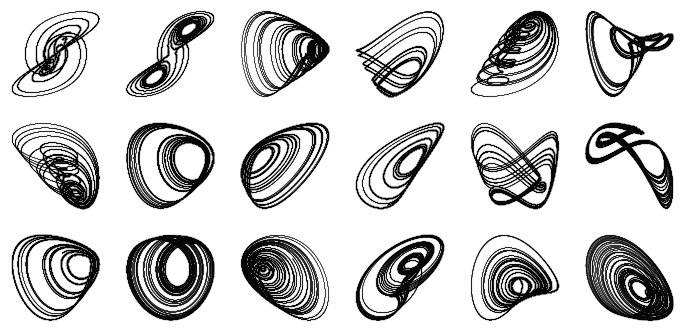

In [4]:
np.random.seed(0)
all_ensembles = list()
plt.figure(figsize=(12, 12))
for i, model in enumerate([SprottB(), SprottC(), SprottD(), SprottE(), SprottF(), SprottG(), 
              SprottH(), SprottI(), SprottJ(), SprottK(), SprottL(), SprottM(),
              SprottN(), SprottO(),SprottP(), SprottQ(), SprottR(), SprottS()]):
    
    
#     tpts = resample_timepoints(model, ic, tpts, pts_per_period=800)
    sol = model.make_trajectory(100000)
    
    plt.subplot(6, 6, i+1)
    plt.plot(sol[0], sol[1], '.k', markersize=.1)

#     ensemble = generate_ic_ensemble(model, tpts, 5, frac_perturb_param=.2)
#     all_ensembles.append(ensemble)
    
    plt.axis('off')

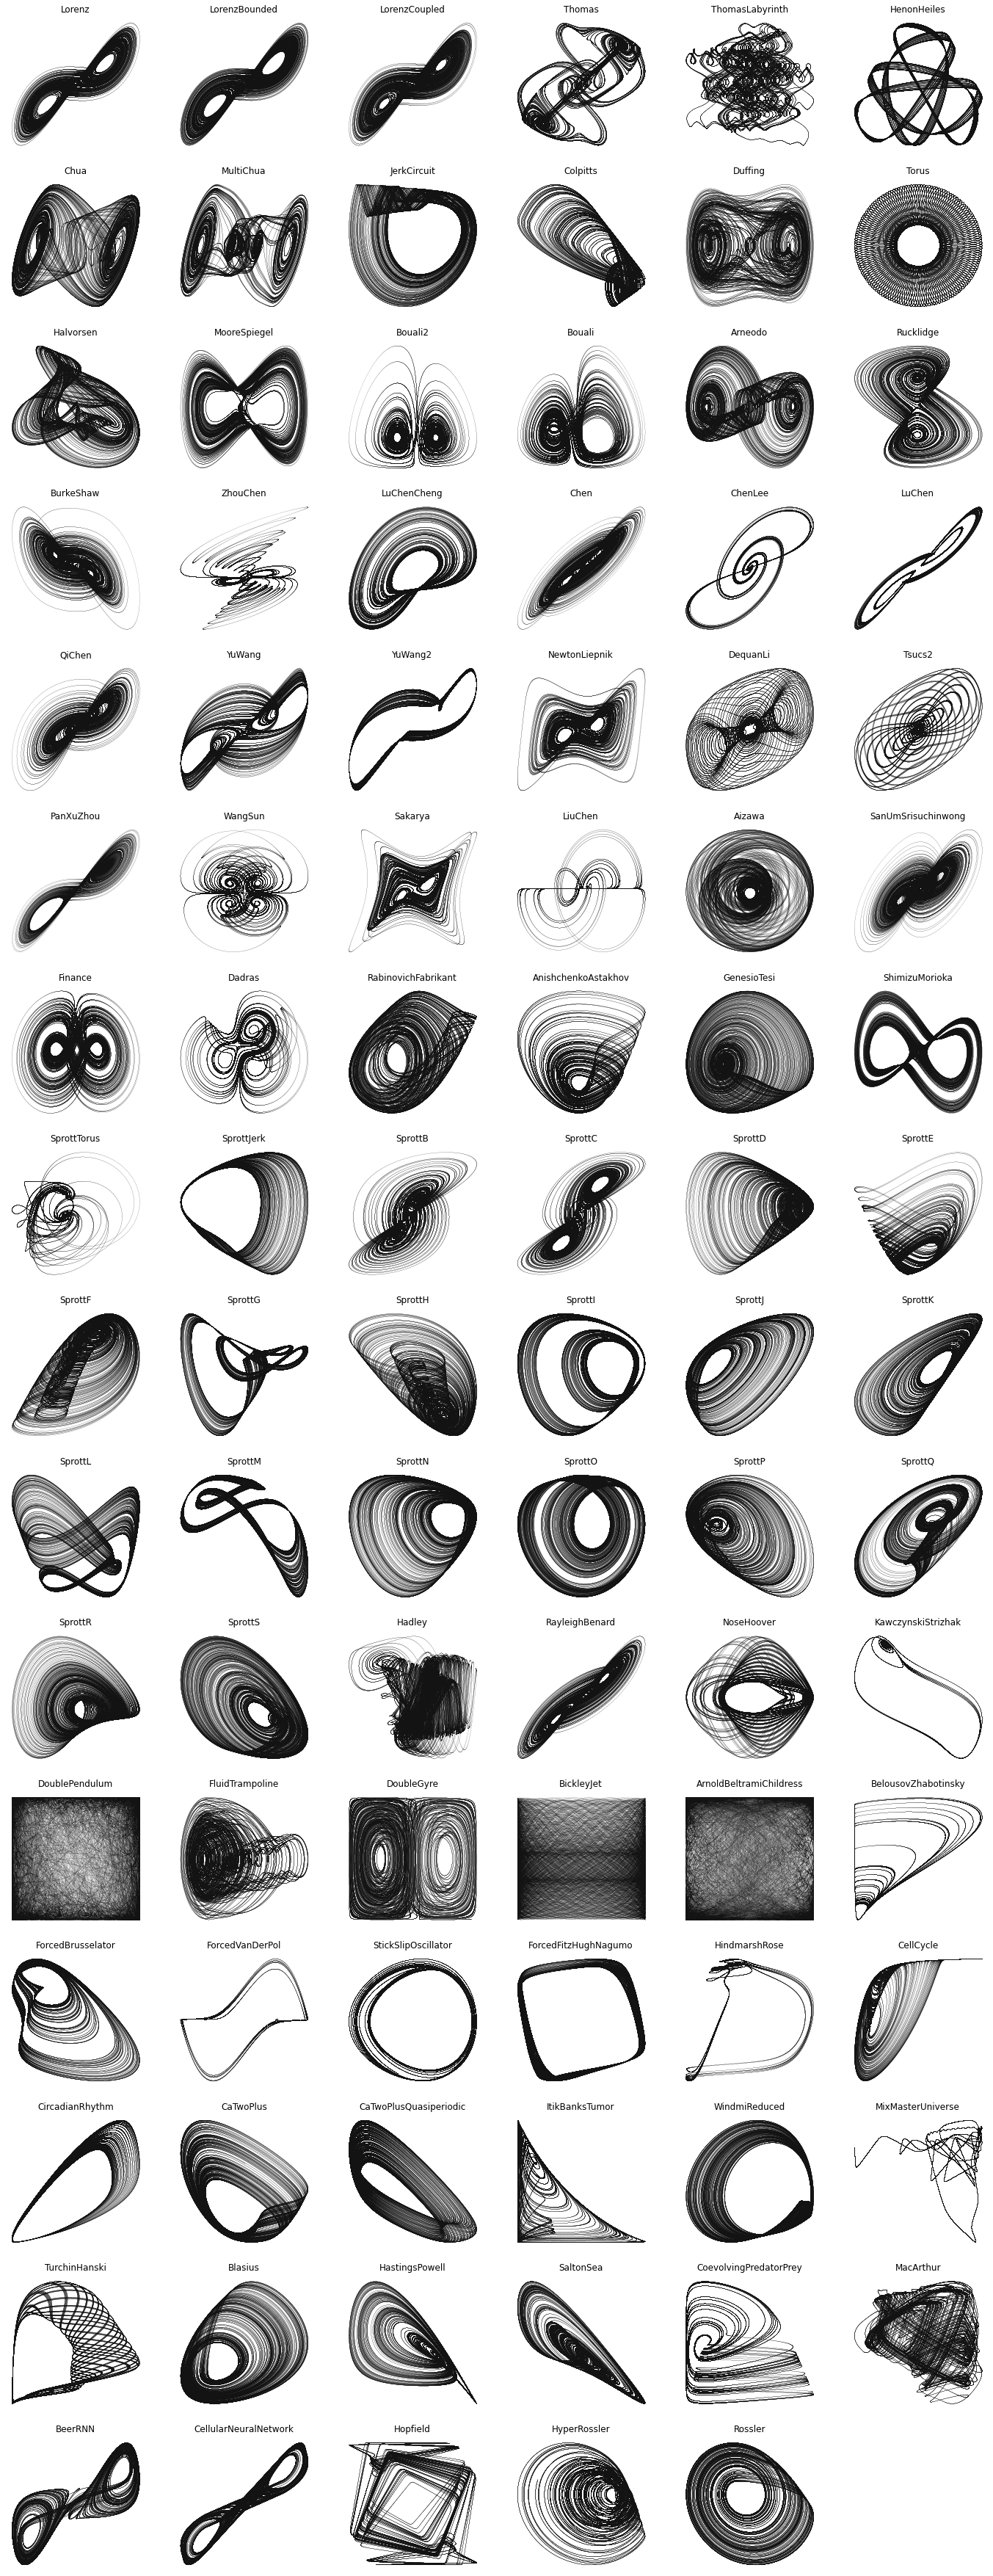

In [13]:

all_attractors = get_attractor_list()

num_cols = 6
num_rows = int(np.ceil(len(all_attractors) / num_cols))
plt.figure(figsize=(num_cols*4, num_rows*4))
for i, item in enumerate(all_attractors):
    
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(1000000)
    
    # Map unbounded indices to compact interval
    if "unbounded_indices" in list(eq._load_data().keys()):
        for ind in eq._load_data()["unbounded_indices"]:
            sol[ind] = np.sin(sol[ind]) 
    
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(sol[0], sol[1], '.k', markersize=.03)
    plt.gca().title.set_text(item)
    plt.gca().axis('off')

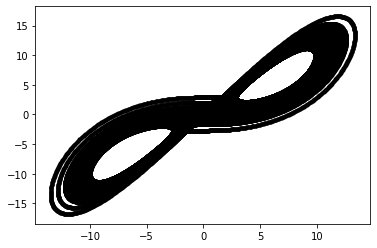

In [14]:
## Simulate a single example

eq = PanXuZhou()

sol = PanXuZhou().make_trajectory(100000)

plt.plot(sol[0], sol[1], '.k')

## Find timescales and dt and write to databse

+ Numerical integration timestep is determined by the highest significant frequency in the power spectrum
+ Initial conditions are chosen to lie on the attractor, but as close to one other as possible (align phases)
+ Certain cases: BickleyJet, StickSlipOscillator fail and require manual fine-tuning of dt

In [88]:
import json

import thom
from thom.utils import standardize_ts, find_characteristic_timescale, freq_from_autocorr, freq_from_fft, resample_timepoints, integrate_dyn, signif


with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))



# We will make a local copy of the internal database
path_output = "./chaotic_attractors.json"


all_freqs = list()
all_sols = list()

transient_fraction = .25
total_length = 40000*10

for item in list(data.keys()):
# for item in ["FluidTrampoline"]:
    
    eq = getattr(thom, item)()
    
    try:
        pts_per_period = 1000
        base_freq = 1 / pts_per_period
        sol0 = eq.make_trajectory(total_length)
        eq.ic = list(sol0[:, -1])
        sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]

        for i in range(5):
            # freq = freq_from_autocorr(sol[0])
            # freq = freq_from_fft(sol[0])
            # freq = 1/find_characteristic_timescale(sol[0])
            freq = np.max(find_significant_frequencies(sol[0]))
            period = base_freq / freq
            eq.dt = eq.dt * period # larger period needs larger timestep
            sol0 = eq.make_trajectory(total_length)
            eq.ic = list(sol0[:, -1])
            sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]
            print(freq, end = " ")
        print("\n")

        all_sols.append(sol)

        freq2 = freq_from_fft(sol[0])
        all_freqs.append((freq, freq2))

        data[item]["initial_conditions"] = [signif(item, 8) for item in eq.ic]
        data[item]["dt"] = signif(eq.dt, 4)
    
    except Exception as e:
        print(e)
        pass

# Save an updated copy of the database
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

95
0.0011966666666666666 0.0010033333333333333 0.001 0.001 0.00083 



## Find and write period of each attractor
+ Expressed in units of dt

In [44]:
# We will make a local copy of the internal database
path_output = "./chaotic_attractors.json"


total_length = 40000*10

with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))

for item in list(data.keys()):
    
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    period = 1/freq_from_fft(sol[0])
    
    data[item]["period"] = signif(period, 5)
    print(period)
    
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

95
54705.413036419755
20045.873194426378
19815.14355636749
34863.671836225476
837085.562180407
2503.3165941229477
15046.245409157611
824450.0092796145
6426.3341378629575
823816.7242537452
11601.967225684186
825566.6762572799
827959.7027818084
8089.304445075206
253861.95686368816
28662.199713063612
810884.6268348086
9417.511604224856
9464.056468383313
195468.01082253386
824301.481076755
4952.381035477426
41737.21611650345
19313.92990982284
13783.200745500326
9914.496668012767
10819.418186904124
7011.482313349299
85161.65029923129
10241.304814202891
820942.322499209
63817.65762194096
11167.309683973448
210661.09437313897
1985.1758257911372
16719.33263327681
12195.123212047707
829676.8194886452
826570.0039363945
8828.317154589166
829373.4409640639
10911.784389594075
829492.3566949762
827703.6822258501
16607.18568534406
93215.69411799686
825715.5866391464
828501.3872568101
828817.5006585472
2705.9441885739866
831397.9696918096
828573.0560206011
4004.7413067951707
6016.144402630856
4003.367

In [ ]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

for item in list(data.keys())[:10]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

## Plot attractors with matching dominant timescales

+ This does not look great, because the sub-leading timescales are clearly more important for some attractors

50
195
220
22
17
2
29
235
6
86


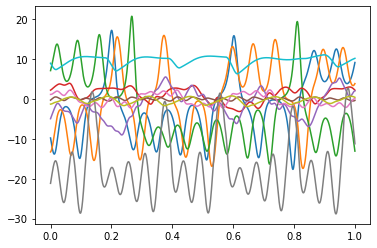

In [121]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

all_attractors = get_attractor_list()

for item in all_attractors[:10]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

In [13]:

from numpy.fft import rfft
from scipy.signal import blackmanharris, fftconvolve, periodogram


def surrogate_time_series(sig):
    """
    Construct a surrogate time series
    """
    


1.3333333333333333e-05

In [27]:

# insert a control function that takes the current values of all vars and adds forcing

# various functions for sampling from each system, and removing transients

# function that goes to numba

# function that couples attractors together (can use slaving to force chaos)

In [ ]:
#https://stackoverflow.com/questions/1796180/how-can-i-get-a-list-of-all-classes-within-current-module-in-python

In [ ]:
## Some day have an API working

import inspect


def generate_data(model, n_samples, params, frac_perturb_param=.1, 
                             n_classes=2, frac_transient=0.1, 
                             ic_range=None,
                            random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.

    model : an instantiation of a dynamical system
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """

    num_per_class = int(n_samples/n_classes)

    params = inspect.getfullargspec(model.__init__).defaults # get default values of params
    
    params = model.get_params()

    param_fractional_perturb = frac_perturb*2*(np.random(len(model.default_params)) - 0.5)
    params = model.default_params*param_fractional_perturb

    mod = model(*params)
    
    
    
    
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params